## Coffee Roasting Model 

here we are going to build a model to predict wheter coffee is roasted correctly based on input features temperature and time

In [1]:
import numpy as np
import pandas as pd

In [2]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

ignore the above function its just used to generate the dataset

In [3]:
x_train,y_train = load_coffee_data()

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Normalizing the data 

We know that foe Gradient Descent to run well we require our data to be normalized

Fitting the weights to the data (back-propagation) will proceed more quickly if the data is normalized. This is the same procedure where features in the data are each normalized to have a similar range. 
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model.

In [5]:
print("Before Normalization")
print(f"x1, max value = {np.max(x_train[:,0])} and min value = {np.min(x_train[:,0])}")
print(f"x2, max value = {np.max(x_train[:,1])} and min value = {np.min(x_train[:,1])}")

Before Normalization
x1, max value = 284.99434167453603 and min value = 151.32372212128612
x2, max value = 15.454206928801511 and min value = 11.512747082472469


In [6]:
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(x_train)
x_norm = norm(x_train)
print("After Normalization")
print(f"x1, max value = {np.max(x_norm[:,0])} and min value = {np.min(x_norm[:,0])}")
print(f"x2, max value = {np.max(x_norm[:,1])} and min value = {np.min(x_norm[:,1])}")

After Normalization
x1, max value = 1.659753680229187 and min value = -1.6852186918258667
x2, max value = 1.793238878250122 and min value = -1.6996712684631348


Thus we normalized the data and see that our data is distributed more generally than before

In [7]:
print(x_train.shape)
print(y_train.shape)

(200, 2)
(200, 1)


Tile/copy is used in our data to increase the training set size and reduce the number of training epochs.

In [8]:
x_tr = np.tile(x_norm,(1000,1))
y_tr = np.tile(y_train,(1000,1))
print(x_tr.shape)
print(y_tr.shape)

(200000, 2)
(200000, 1)


## TensorFlow Model (Forward Prop )
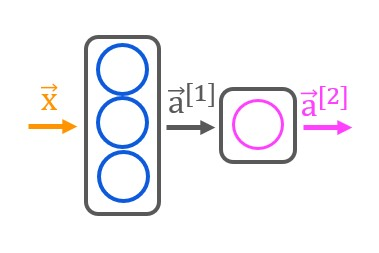
Let's build the "Coffee Roasting Network" described . There are two layers with sigmoid activations.

In [9]:
tf.random.set_seed(1234)   # applied to achieve consistent results
model = Sequential([
    tf.keras.Input(shape=(2,)),
    Dense(3 , activation='sigmoid' , name='L1'),
    Dense(1 , activation='sigmoid' , name='L2')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 3)                 9         
                                                                 
 L2 (Dense)                  (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. 

The `model.summary()` provides a description of the network:

Total params show the number of parameters in the neural network model

In [11]:
l1_param = 2*3+3
l2_param = 3*1+1
print(f"number of parameters of L1 = {l1_param}")
print(f"number of parameters of L2 = {l2_param}")

number of parameters of L1 = 9
number of parameters of L2 = 4


Let's examine the weights and biases Tensorflow has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [12]:
w1,b1 = model.get_layer('L1').get_weights()
w2,b2 = model.get_layer('L2').get_weights()
print(f"Layer 1 weights w = {w1} and b = {b1}")
print(f"Layer 2 weights w = {w2} and b = {b2}")

Layer 1 weights w = [[-0.05941796 -0.702311    0.89408195]
 [ 0.54477966 -0.3131448  -0.31258696]] and b = [0. 0. 0.]
Layer 2 weights w = [[-0.8534627 ]
 [ 0.02419293]
 [ 0.7343545 ]] and b = [0.]


- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [13]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    x_tr,y_tr,            
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 6s 847us/step - loss: 0.1834
Epoch 2/10
6250/6250 [==============================] - 5s 770us/step - loss: 0.1205
Epoch 3/10
6250/6250 [==============================] - 4s 642us/step - loss: 0.0516
Epoch 4/10
6250/6250 [==============================] - 4s 673us/step - loss: 0.0181
Epoch 5/10
6250/6250 [==============================] - 4s 638us/step - loss: 0.0119
Epoch 6/10
6250/6250 [==============================] - 5s 755us/step - loss: 0.0085
Epoch 7/10
6250/6250 [==============================] - 4s 662us/step - loss: 0.0062
Epoch 8/10
6250/6250 [==============================] - 4s 656us/step - loss: 0.0045
Epoch 9/10
6250/6250 [==============================] - 4s 665us/step - loss: 0.0033
Epoch 10/10
6250/6250 [==============================] - 4s 659us/step - loss: 0.0025


#### Epochs and batches
In the `compile` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.

**Updated Weights** after running the adam optimizer

In [14]:
w1,b1 = model.get_layer('L1').get_weights()
w2,b2 = model.get_layer('L2').get_weights()
print(f"w1 = {w1} and b1 = {b1}")
print(f"w2 = {w2} and b2 = {b2}")

w1 = [[-0.0213812  14.38747    12.927354  ]
 [-8.881252   11.950185    0.33259183]] and b1 = [-11.156101    1.7449316  13.480341 ]
w2 = [[-45.44244 ]
 [-43.347683]
 [ 38.43877 ]] and b2 = [-12.38905]


#### predicting 

In [15]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 63ms/step
predictions = 
 [[9.8811650e-01]
 [3.0491073e-08]]


In [16]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]
